In [1]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
import json
import ntpath
import mixamo_helper as mm_helper
from mixamo_helper import Mixamo
from IPython.display import clear_output
import copy

## **load mixamo json**

In [2]:
json_object = None
file_name = 'output/mixamo_T_pose.gif.json_mixamo.json' 
with open(file_name) as f:
    json_object = json.load(f)

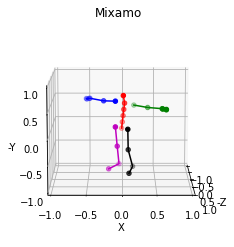

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'score': 0.9990859627723694, 'name': 'Hips', 'parent': -1}
{'x': 0.0918450579047203, 'y': 0.008321262896060944, 'z': -0.06470819562673569, 'score': 0.9990695118904114, 'name': 'LeftLeg', 'parent': 0}
{'x': -0.09308415651321411, 'y': -0.008823947049677372, 'z': 0.0650477483868599, 'score': 0.9991024136543274, 'name': 'RightLeg', 'parent': 0}


In [3]:
current_frame = 55
mm_helper.draw_mixamo(json_object, current_frame, 0)
current_keypoints = json_object["frames"][current_frame]["keypoints3D"]
print(current_keypoints[Mixamo.Hips])
print(current_keypoints[Mixamo.LeftLeg])
print(current_keypoints[Mixamo.RightLeg])

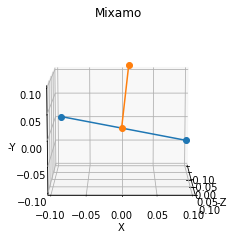

In [4]:
draw_list = [[Mixamo.LeftLeg, Mixamo.RightLeg], 
             [Mixamo.Hips, Mixamo.Spine]]


mm_helper.draw_list(json_object, current_frame, draw_lists=draw_list, range= 0.1, azim= 0)

## **Math**

In [5]:
import glm
import pyglm_helper as glmh

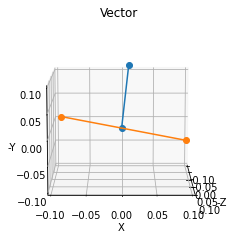

vec3(    0.0918451,   0.00832126,   -0.0647082 )
vec3(   -0.0930842,  -0.00882395,    0.0650477 )


In [6]:
glm_list, visibility_list, parent_list = mm_helper.frame_json_to_glm_vec_list(json_object, current_frame)
hip_v = glm_list[Mixamo.Hips]
spine_v = glm_list[Mixamo.Spine]
leftleg_v = glm_list[Mixamo.LeftLeg]
rightleg_v = glm_list[Mixamo.RightLeg]

glmh.draw_list([hip_v, spine_v,leftleg_v, rightleg_v], [[0, 1],[2,3]], azim = 0, range = 0.1)
print(leftleg_v)
print(rightleg_v)

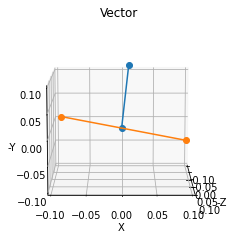

In [7]:
transform = glm.rotate(glm.mat4(1.0), glm.radians(0), glm.vec3(0.0, 0.0, 1.0))
glmh.draw_list([transform*hip_v, transform*spine_v, transform*leftleg_v, transform*rightleg_v], [[0, 1],[2,3]], azim = 0, range = 0.1)


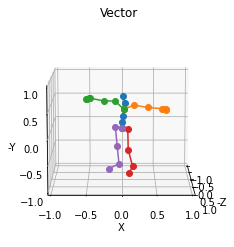

In [8]:
idx_group = mm_helper.get_idx_group()
glmh.draw_list([transform*v for v in glm_list], idx_group, azim=0)

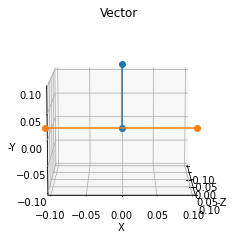

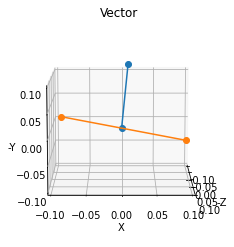

vec3(    0.0918451,   0.00832126,   -0.0647082 )
vec3(   -0.0928592,  -0.00841314,    0.0654227 )
vec3(    0.0918451,   0.00832126,   -0.0647082 )
vec3(   -0.0930842,  -0.00882395,    0.0650477 )
0.11265837401151657
0.11265837401151657


In [9]:
glm.distance(hip_v, rightleg_v)
b_rightleg = glm.vec3(-glm.distance(hip_v, rightleg_v), 0, 0)
b_leftleg = glm.vec3(glm.distance(hip_v, leftleg_v), 0, 0)
b_spine = glm.vec3(0,-glm.distance(hip_v, spine_v), 0)
norm_b_leftleg = glm.normalize(b_leftleg)
norm_leftleg = glm.normalize(leftleg_v)
glmh.draw_list([hip_v, b_spine, b_leftleg, b_rightleg], [[0, 1],[2,3]], azim = 0, range = 0.1)

transform = glm.rotate(glm.mat4(1.0), glm.acos(glm.dot(norm_b_leftleg, norm_leftleg)) ,glm.cross(b_leftleg, leftleg_v))

glmh.draw_list([transform*hip_v, transform*b_spine, transform*b_leftleg, transform*b_rightleg], [[0, 1],[2,3]], azim = 0, range = 0.1)
print(transform*b_leftleg)
print(transform*b_rightleg)
print(leftleg_v)
print(rightleg_v)
print(glm.distance(hip_v, transform* b_leftleg))
print(glm.distance(hip_v, transform* leftleg_v))

In [13]:
def get_hip_transform(glmList):
    # b_rightleg = glm.vec3(-glm.distance(glmList[Mixamo.Hips], glmList[Mixamo.RightLeg]), 0, 0)
    b_leftleg = glm.vec3(glm.distance(glmList[Mixamo.Hips], glmList[Mixamo.LeftLeg]), 0, 0)
    # b_spine = glm.vec3(0,-glm.distance(glmList[Mixamo.Hips], glmList[Mixamo.Spine]), 0)

    norm_b_leftleg = glm.normalize(b_leftleg)
    norm_leftleg = glm.normalize(glmList[Mixamo.LeftLeg])
    transform = glm.rotate(glm.mat4(1.0), glm.acos(glm.dot(norm_b_leftleg, norm_leftleg)) ,glm.cross(b_leftleg, leftleg_v))
    return glm.inverse(transform)

101


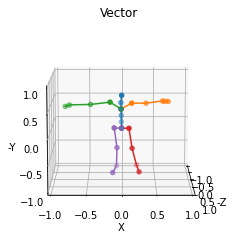

In [14]:
frame_size = len(json_object["frames"])
print(frame_size)
all_frame_glm_list = [] 
for idx in range(0 , frame_size):
    glm_list1, visibility_list, parent_list = mm_helper.frame_json_to_glm_vec_list(json_object, idx)
    hip_transform = get_hip_transform(glm_list1)
    all_frame_glm_list.append(copy.deepcopy([hip_transform*v for v in glm_list1]))

# for idx in range(0, frame_size):
#     clear_output()
#     glmh.draw_list([v for v in all_frame_glm_list[idx]], idx_group, azim=0)
glmh.glm_list_to_gif(all_frame_glm_list, fps=json_object["ticksPerSecond"], save_path='./screenshot/')